Feature count: 18
Supervised shape: (10862, 432) (10862,)
Train segment: (8689, 432) Test segment: (2173, 432)
RMSE: 8705.0853
MAE:  63.4223
MAPE: 34.05%
R2:   0.8163


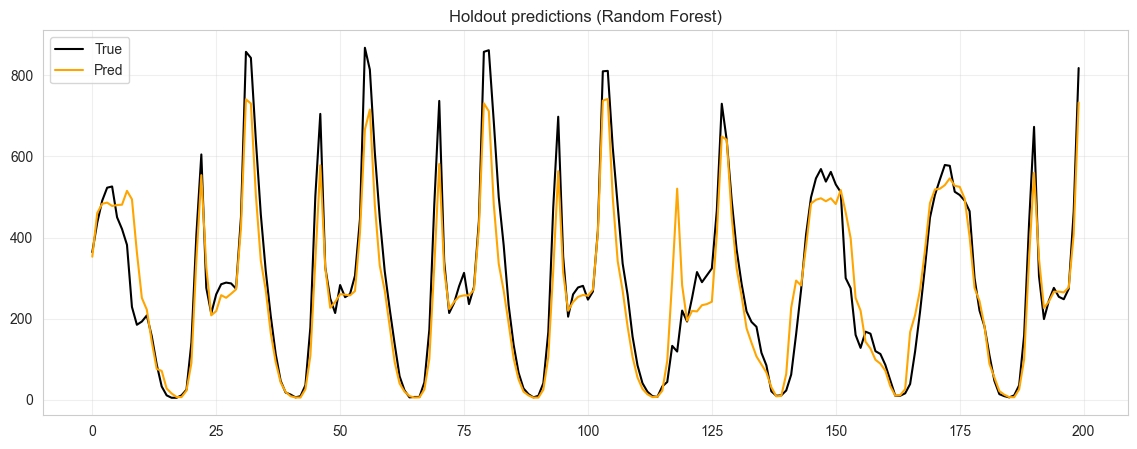

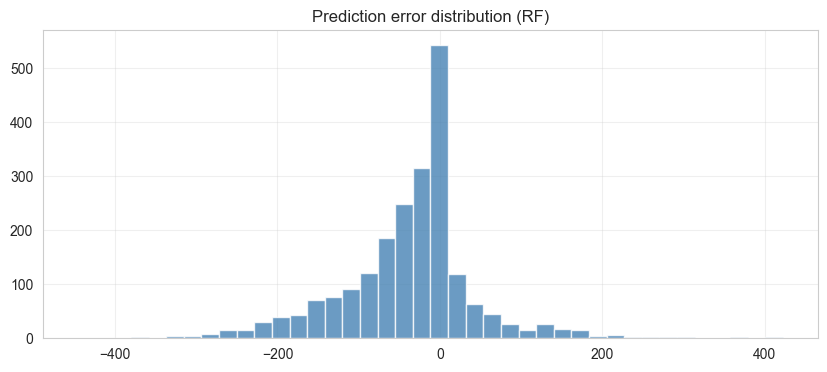

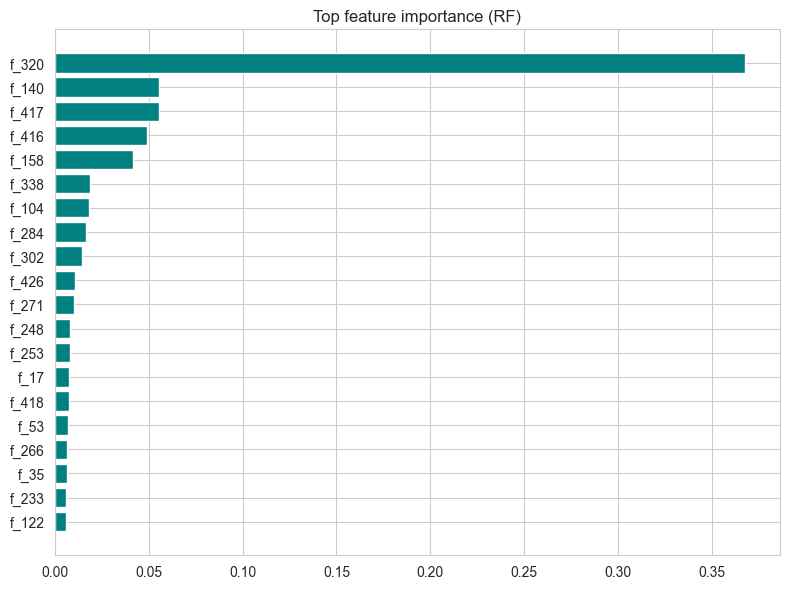

Done.


In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from typing import Optional, Callable

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

DATA_TRAIN_PATH = "data/train.csv"
DATA_TEST_PATH = "data/test.csv"
target_col = "count"

def read_data(path):
    df = pd.read_csv(path, parse_dates=["datetime"])

    season = pd.get_dummies(df['season'], prefix='season')
    df = pd.concat([df, season], axis=1)

    weather = pd.get_dummies(df['weather'], prefix='weather')
    df = pd.concat([df, weather], axis=1)

    df.drop(['season', 'weather'], axis=1, inplace=True)

    dt_index = pd.DatetimeIndex(df.datetime)
    df['hour'] = dt_index.hour
    df['day'] = dt_index.dayofweek
    df['month'] = dt_index.month
    df['year'] = dt_index.year.map({2011: 0, 2012: 1})

    df.drop('datetime', axis=1, inplace=True)

    # Drop train-only columns if present
    drop_cols = [c for c in ['casual', 'registered'] if c in df.columns]
    if drop_cols:
        df.drop(columns=drop_cols, inplace=True)

    return df

train_df = read_data(DATA_TRAIN_PATH)
test_df = read_data(DATA_TEST_PATH)

feature_cols = [c for c in train_df.columns if c != target_col and c in test_df.columns]
print(f"Feature count: {len(feature_cols)}")

scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_cols].values.astype(np.float32))
train_target = train_df[target_col].values.astype(np.float32)


def build_lag_supervised(features, target, context_length):
    X_list, y_list = [], []
    for i in range(len(target) - context_length):
        X_window = features[i:i + context_length].reshape(-1)
        y_val = target[i + context_length]
        X_list.append(X_window)
        y_list.append(y_val)
    return np.vstack(X_list).astype(np.float32), np.array(y_list, dtype=np.float32)


context_length = 24
X_all, y_all = build_lag_supervised(train_features, train_target, context_length)
print("Supervised shape:", X_all.shape, y_all.shape)

# Train / holdout split (time-ordered)
train_ratio = 0.8
n_train = int(len(X_all) * train_ratio)
X_model, X_test_hold = X_all[:n_train], X_all[n_train:]
y_model, y_test_hold = y_all[:n_train], y_all[n_train:]
print("Train segment:", X_model.shape, "Test segment:", X_test_hold.shape)

# Train / validation for consistency (no early stopping for RF, but keep split)
X_tr, X_val, y_tr, y_val = train_test_split(X_model, y_model, test_size=0.15, shuffle=False)

# Train a Random Forest regressor
rf_params = {
    "n_estimators": 200,
    "max_depth": 16,
    "min_samples_leaf": 1,
    "random_state": 42,
    "n_jobs": -1
}
rf = RandomForestRegressor(**rf_params)
rf.fit(X_tr, y_tr)

# Evaluate on holdout
y_pred = rf.predict(X_test_hold)

rmse = mean_squared_error(y_test_hold, y_pred)  # kept same behavior as original notebook (MSE labeled RMSE)
mae = mean_absolute_error(y_test_hold, y_pred)
with np.errstate(divide='ignore', invalid='ignore'):
    mape = np.mean(np.abs((y_test_hold - y_pred) / np.clip(np.abs(y_test_hold), 1e-6, None))) * 100
r2 = r2_score(y_test_hold, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2:   {r2:.4f}")

# Plot predictions vs actual
n_plot = min(200, len(y_test_hold))
idx = np.arange(n_plot)
plt.figure(figsize=(14, 5))
plt.plot(idx, y_test_hold[:n_plot], label="True", color="black")
plt.plot(idx, y_pred[:n_plot], label="Pred", color="orange")
plt.title("Holdout predictions (Random Forest)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Error distribution
errors = y_pred - y_test_hold
plt.figure(figsize=(10, 4))
plt.hist(errors, bins=40, color="steelblue", alpha=0.8)
plt.title("Prediction error distribution (RF)")
plt.grid(alpha=0.3)
plt.show()

# Feature importance (by RF feature importances)
if hasattr(rf, "feature_importances_"):
    # note: original features are flattened windows; label accordingly
    importance = rf.feature_importances_
    # get top 20 indices
    top_idxs = np.argsort(importance)[-20:][::-1]
    labels = [f"f_{i}" for i in top_idxs]
    vals = importance[top_idxs]
    plt.figure(figsize=(8, 6))
    plt.barh(labels[::-1], vals[::-1], color="teal")
    plt.title("Top feature importance (RF)")
    plt.tight_layout()
    plt.show()
else:
    print("No feature importance available.")

print("Done.")


In [2]:
# ACPI Implementation (using the ACPI package as in the original notebook)
from acpi import ACPI
from acpi.utils import compute_coverage

# Split holdout set into calibration and test sets
cal_size = 0.4
n_cal = int(len(X_test_hold) * cal_size)
X_cal, X_test_acpi = X_test_hold[:n_cal], X_test_hold[n_cal:]
y_cal, y_test_acpi = y_test_hold[:n_cal], y_test_hold[n_cal:]

print(f"Calibration set size: {len(X_cal)}")
print(f"ACPI Test set size: {len(X_test_acpi)}")


class RFACPIWrapper:
    """ACPI wrapper for a scikit-learn RandomForestRegressor."""
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        return self.model.predict(X)


# Wrap the trained Random Forest model
rf_wrapper = RFACPIWrapper(rf)


Calibration set size: 869
ACPI Test set size: 1304


In [3]:
# Initialize and fit ACPI
alpha = 0.20
acpi_model = ACPI(
    model_cali=rf_wrapper,
    n_estimators=200,
    max_depth=25,
    min_node_size=15
)

print("\nFitting ACPI model...")
acpi_model.fit(X_cal, y_cal)
acpi_model.fit_calibration(X_cal, y_cal, quantile=(1 - alpha), only_qrf=True)
print("ACPI fitting complete.")

# Generate prediction intervals
y_lower, y_upper = acpi_model.predict_pi(X_test_acpi, method="qrf")

# Evaluate coverage
coverage = compute_coverage(y_test_acpi, y_lower, y_upper)
print(f"\nACPI Coverage: {coverage:.4f} (Target: {1-alpha:.4f})")

# Get point predictions for comparison
y_pred_acpi = rf_wrapper.predict(X_test_acpi)



Fitting ACPI model...


100%|██████████| 50/50 [02:08<00:00,  2.56s/it]


ACPI fitting complete.

ACPI Coverage: 0.8489 (Target: 0.8000)


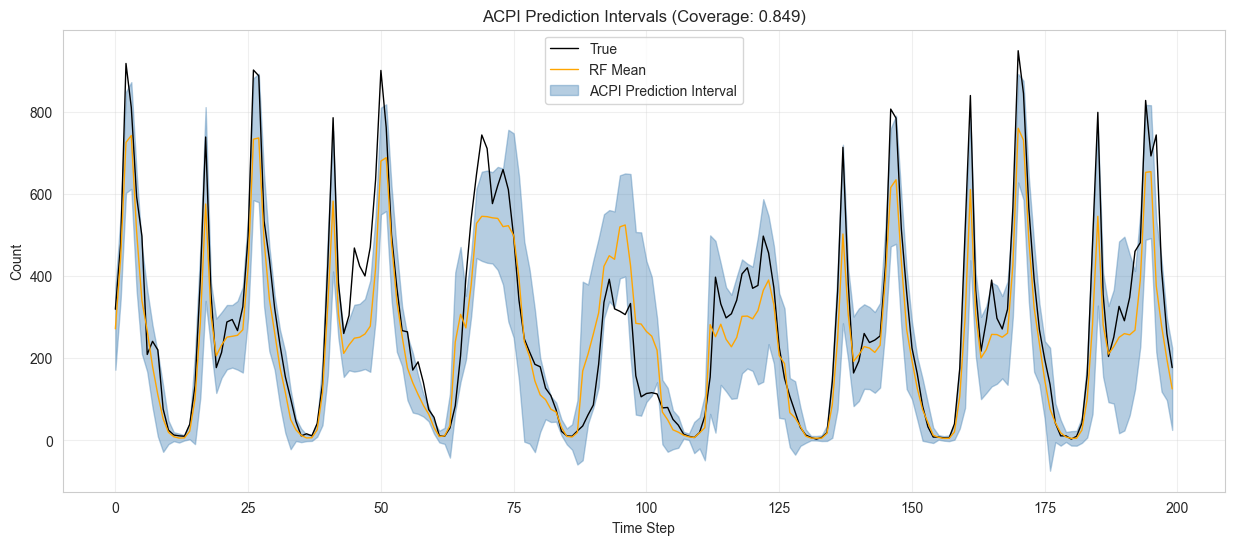

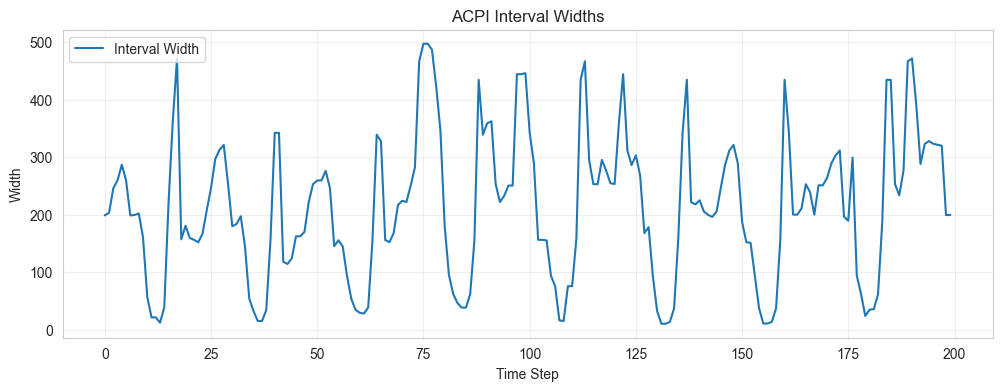

Below: 14 (1.07%)
Above: 183 (14.03%)
Within: 1107 (84.89%)


In [4]:
# Plot ACPI Results

# Plot predictions with intervals
n_plot_acpi = min(200, len(y_test_acpi))
idx_acpi = np.arange(n_plot_acpi)

plt.figure(figsize=(15, 6))
plt.plot(idx_acpi, y_test_acpi[:n_plot_acpi], label="True", color="black", linewidth=1)
plt.plot(idx_acpi, y_pred_acpi[:n_plot_acpi], label="RF Mean", color="orange", linewidth=1)
plt.fill_between(idx_acpi, y_lower[:n_plot_acpi], y_upper[:n_plot_acpi], color="steelblue", alpha=0.4, label="ACPI Prediction Interval")
plt.title(f"ACPI Prediction Intervals (Coverage: {coverage:.3f})")
plt.xlabel("Time Step")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot interval widths
interval_widths = y_upper - y_lower
plt.figure(figsize=(12, 4))
plt.plot(interval_widths[:n_plot_acpi], label="Interval Width")
plt.title("ACPI Interval Widths")
plt.xlabel("Time Step")
plt.ylabel("Width")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Coverage statistics
n_below = (y_test_acpi < y_lower).sum()
n_above = (y_test_acpi > y_upper).sum()
n_within = len(y_test_acpi) - n_below - n_above
total = len(y_test_acpi)

print(f"Below: {n_below} ({n_below/total:.2%})")
print(f"Above: {n_above} ({n_above/total:.2%})")
print(f"Within: {n_within} ({n_within/total:.2%})")
